# Exploratory Data Analysis for Acoustic Anomaly Detection
#
This notebook analyzes three audio recordings:
- A **complete recording** that contains all sounds including anomalies,
- An **anomalous recording** that includes only the anomalous segments,
- A **normal recording** that has been "cleaned" for training.
#
In this analysis we extract and visualize various features:
- **Time-domain**: Raw waveform.
- **Frequency-domain**: Mel-spectrogram, FFT.
- **Time-frequency**: STFT spectrogram.
- **Multi-resolution**: Wavelet transform.
- **High-level features**: MFCCs, spectral features, and zero-crossing rate.
#
These analyses help reveal both global and local characteristics of the signals for anomaly detection.


## 1. Imports and Setup


In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft
import seaborn as sns
from matplotlib import ticker
import pywt

# Global plot settings
plt.rcParams.update({'font.size': 10})
sns.set(style="whitegrid")



## 2. Utility Functions
#
This section contains helper functions for:
- Loading audio files.
- Generating and plotting waveforms and Mel-spectrograms.
- Extracting high-level audio features (MFCC, spectral, and temporal).
- Computing and visualizing FFT, STFT, and wavelet transforms.


In [7]:
def load_audio_file(file_path, label):
    """Load a .wav file and return the audio signal, label, and sample rate."""
    if os.path.isfile(file_path) and file_path.endswith('.wav'):
        audio, sr = librosa.load(file_path, sr=None)
        return audio, label, sr
    else:
        raise ValueError(f"Invalid .wav file: {file_path}")


def generate_mel_spectrogram(audio, sr, n_mels=128, n_fft=1024, hop_length=512):
    """
    Generate a normalized Mel-spectrogram from an audio signal.
    Normalization scales the decibel values between 0 and 1.
    """
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)) ** 2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_norm


def plot_waveform(audio, sr, title="Waveform"):
    """Plot the raw audio waveform."""
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


def plot_mel_spectrogram(mel_spec, sr, title="Mel-Spectrogram", xlim=None, nbins=15, save_path=None):
    """Plot a Mel-spectrogram with time formatted as MM:SS."""
    fig, ax = plt.subplots(figsize=(10, 6))
    img = librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
    ax.set(title=title, xlabel='Time (s)', ylabel='Frequency (Hz)')
    if xlim:
        ax.set_xlim(xlim)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x // 60):02d}:{int(x % 60):02d}"))
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def extract_features(audio, sr, n_mfcc=13):
    """
    Extract high-level audio features:
    - MFCCs: Mean across time for each of the n_mfcc coefficients.
    - Spectral features: Centroid, rolloff, contrast.
    - Temporal feature: Zero-crossing rate.
    Returns a concatenated feature vector.
    """
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr))

    # Temporal feature
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio))

    features = np.concatenate([mfccs_mean,
                               [spectral_centroid, spectral_rolloff, spectral_contrast, zero_crossing_rate]])
    return features


def plot_feature_distributions(feature_data, feature_names, title_prefix="Feature"):
    """
    Plot histograms for each feature.
    feature_data should be a dict with keys corresponding to audio types.
    """
    num_features = feature_data[list(feature_data.keys())[0]].shape[1]
    plt.figure(figsize=(15, 2 * num_features))
    for i in range(num_features):
        plt.subplot(num_features, 1, i + 1)
        for label, data in feature_data.items():
            sns.histplot(data[:, i], label=label, kde=True, bins=30, alpha=0.6)
        plt.title(f'{title_prefix} Distribution: {feature_names[i]}')
        plt.xlabel(feature_names[i])
        plt.legend()
    plt.tight_layout()
    plt.show()


# Additional Transformations

def compute_fft(audio, sr):
    """
    Compute FFT of the audio signal and return frequencies and amplitude spectrum.
    Also plots the FFT amplitude spectrum.
    """
    N = len(audio)
    yf = fft(audio)
    xf = np.linspace(0.0, sr / 2, N // 2)
    amplitudes = 2.0 / N * np.abs(yf[:N // 2])

    plt.figure(figsize=(10, 4))
    plt.plot(xf, amplitudes)
    plt.title("FFT Amplitude Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return xf, amplitudes


def compute_stft(audio, sr, n_fft=1024, hop_length=512):
    """
    Compute and display the Short-Time Fourier Transform (STFT) spectrogram.
    """
    stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length, cmap='viridis')
    plt.title("STFT Spectrogram (Log-Frequency)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    return stft_result


def compute_wavelet(audio, wavelet='db4', level=5):
    """
    Compute the Discrete Wavelet Transform of the audio signal.
    Plots the wavelet coefficients for each level.
    """
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    plt.figure(figsize=(12, 8))
    for i, coeff in enumerate(coeffs):
        plt.subplot(len(coeffs), 1, i + 1)
        plt.plot(coeff)
        plt.title(f"Wavelet Coefficients Level {i}")
        plt.xlabel("Coefficient Index")
        plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

    return coeffs



## 3. Data Loading
#
We load the three provided audio recordings:
- **Complete**: Contains all sounds including anomalies. 20min audio sample of a real recording, including the anomalies.
- **Anomalous**: Contains only the anomalous segments. Short audio sample of all captured anomalies from 3 microphones.
- **Normal**: The cleaned recording. Concatenated 3 microphone recordings and eliminated anomalies for training purposes.
#
Each file is loaded only once.


In [8]:
# Define paths to the audio files
path_complete = "../../Data/raw/08_livetest_anomalies/output_MIC1_2024-11-07_13-55-00_065414.wav"
path_anomaly = "../../Data/raw/13_real/Anomaly_knackgeräusche.wav"
path_normal = "../../Data/raw/13_real/Normal_knackgeräusche.wav"

# Load the recordings
audio_complete, _, sr_complete = load_audio_file(path_complete, label="Complete")
audio_anomaly, _, sr_anomaly = load_audio_file(path_anomaly, label="Anomalous")
audio_normal, _, sr_normal = load_audio_file(path_normal, label="Normal")

print(f"Complete: {len(audio_complete)} samples at {sr_complete} Hz")
print(f"Anomalous: {len(audio_anomaly)} samples at {sr_anomaly} Hz")
print(f"Normal: {len(audio_normal)} samples at {sr_normal} Hz")

# Ensure sampling rates are consistent for anomaly and normal recordings
assert sr_anomaly == sr_normal, "Sampling rates for anomaly and normal recordings do not match!"


Complete: 52920000 samples at 44100 Hz
Anomalous: 245001 samples at 44100 Hz
Normal: 158661282 samples at 44100 Hz


## 4. Visualization: Raw Audio and Mel-Spectrograms


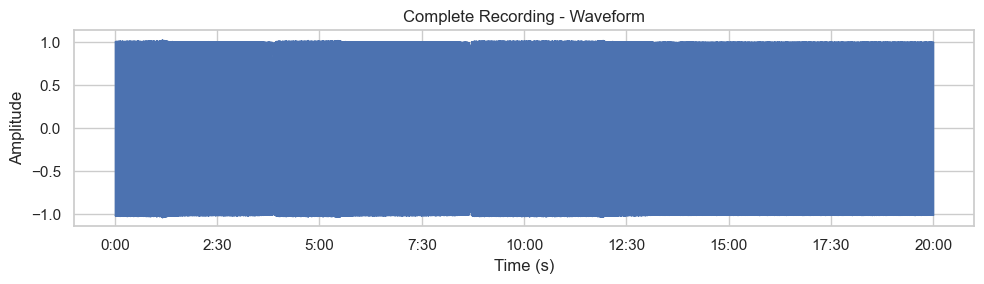

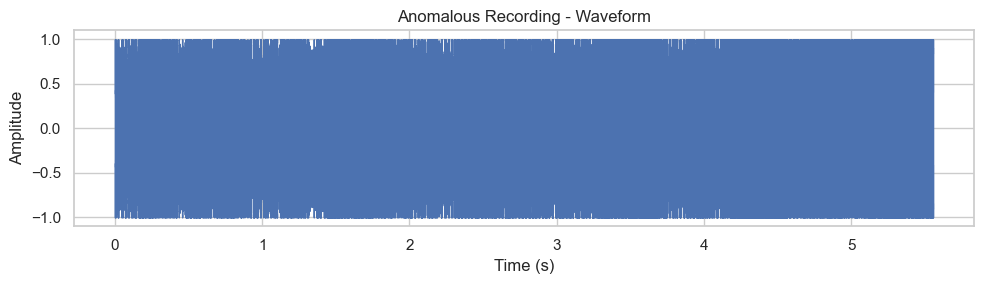

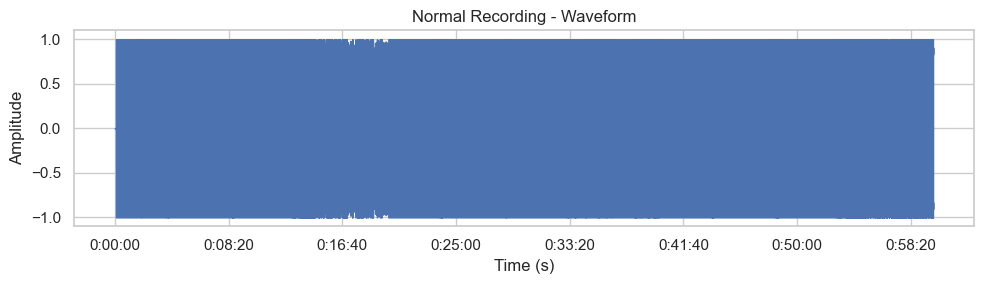

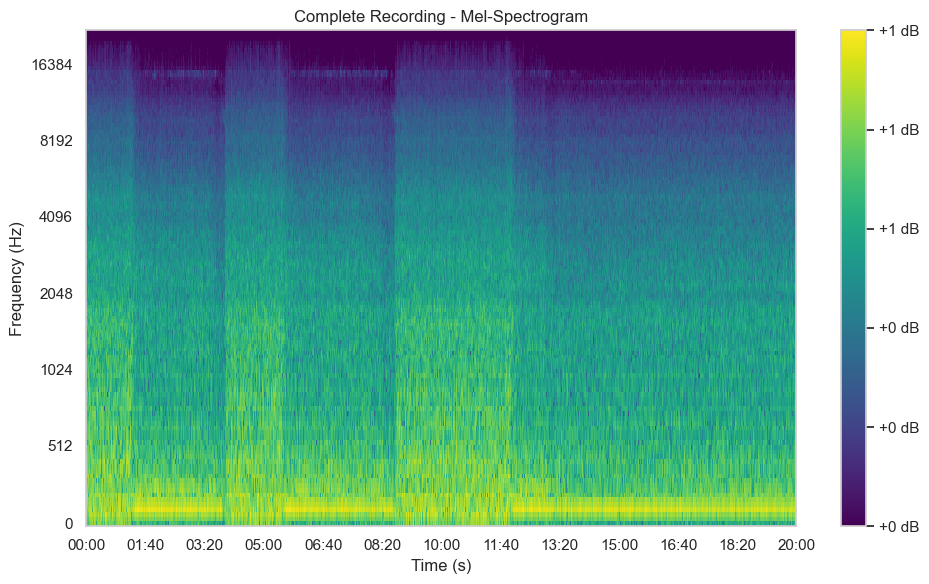

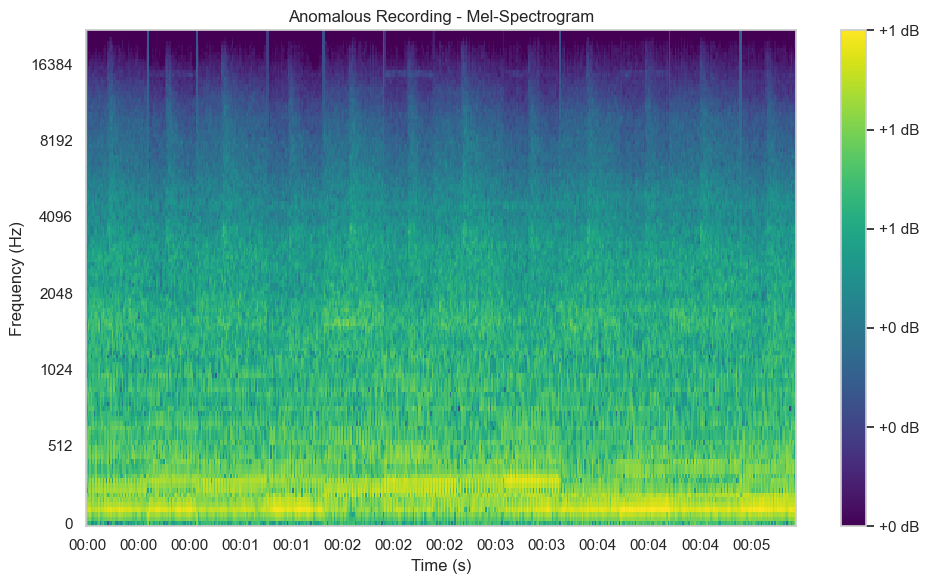

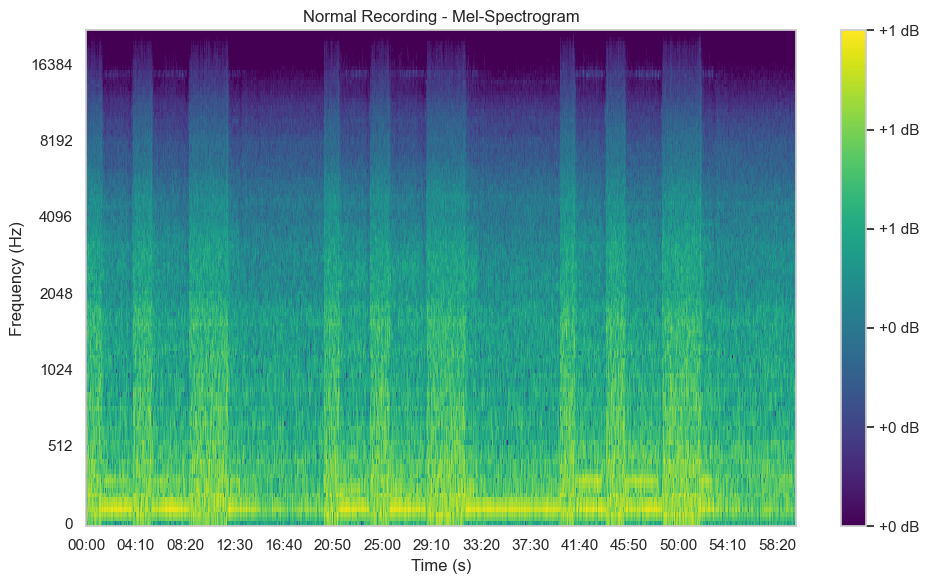

In [9]:
# Plot raw waveforms
plot_waveform(audio_complete, sr_complete, title="Complete Recording - Waveform")
plot_waveform(audio_anomaly, sr_anomaly, title="Anomalous Recording - Waveform")
plot_waveform(audio_normal, sr_normal, title="Normal Recording - Waveform")

# Generate Mel-spectrograms
mel_complete = generate_mel_spectrogram(audio_complete, sr_complete)
mel_anomaly = generate_mel_spectrogram(audio_anomaly, sr_anomaly)
mel_normal = generate_mel_spectrogram(audio_normal, sr_normal)

# Plot Mel-spectrograms
plot_mel_spectrogram(mel_complete, sr_complete, title="Complete Recording - Mel-Spectrogram")
plot_mel_spectrogram(mel_anomaly, sr_anomaly, title="Anomalous Recording - Mel-Spectrogram")
plot_mel_spectrogram(mel_normal, sr_normal, title="Normal Recording - Mel-Spectrogram")


## 5. High-Level Feature Extraction and Analysis
#
We extract and compare key acoustic features:
- **MFCCs**, **spectral features** (centroid, rolloff, contrast),
- **Zero-crossing rate**.
#
These features are combined into a single vector for each recording.


In [6]:
# Extract features for each recording
features_complete = extract_features(audio_complete, sr_complete)
features_anomaly = extract_features(audio_anomaly, sr_anomaly)
features_normal = extract_features(audio_normal, sr_normal)

# Define feature names: 13 MFCCs, then spectral centroid, rolloff, contrast, and zero crossing rate.
mfcc_names = [f"MFCC_{i + 1}" for i in range(13)]
other_names = ["Spectral Centroid", "Spectral Rolloff", "Spectral Contrast", "Zero Crossing Rate"]
feature_names = mfcc_names + other_names
print("Extracted feature names:", feature_names)

# For demonstration, we wrap each feature vector as a 2D array (1 sample per recording)
feature_data = {
    "Complete": features_complete.reshape(1, -1),
    "Anomalous": features_anomaly.reshape(1, -1),
    "Normal": features_normal.reshape(1, -1)
}

# Plot feature distributions (Note: With one value per feature per recording, consider segmentation for distributions)
plot_feature_distributions(feature_data, feature_names, title_prefix="Audio Feature")


KeyboardInterrupt: 

## 6. Additional Transform Analyses: FFT, STFT, and Wavelet Transform
#
In this section we compute and visualize additional transforms to capture complementary signal characteristics.


FFT Analysis for Complete Recording:


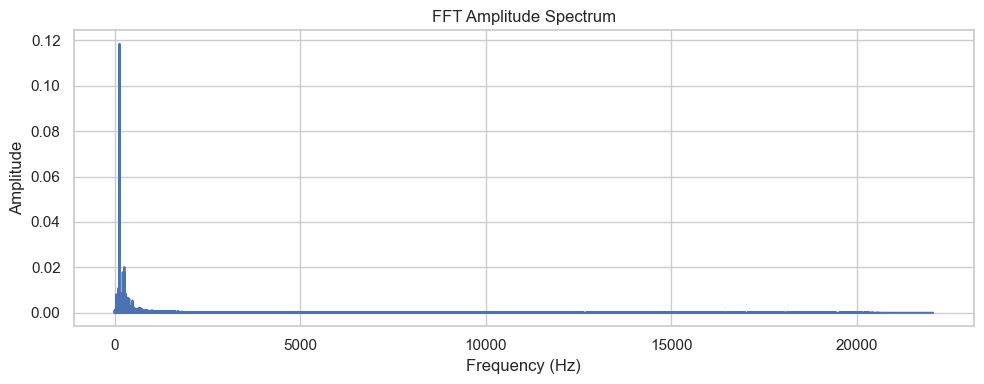

FFT Analysis for Anomalous Recording:


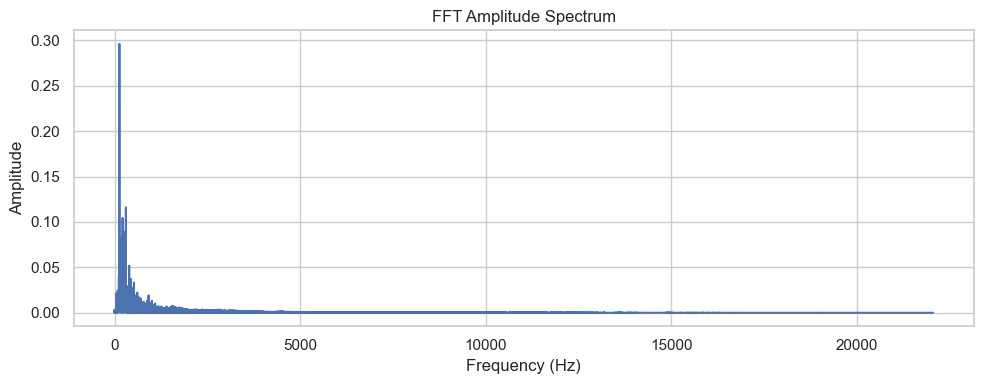

FFT Analysis for Normal Recording:


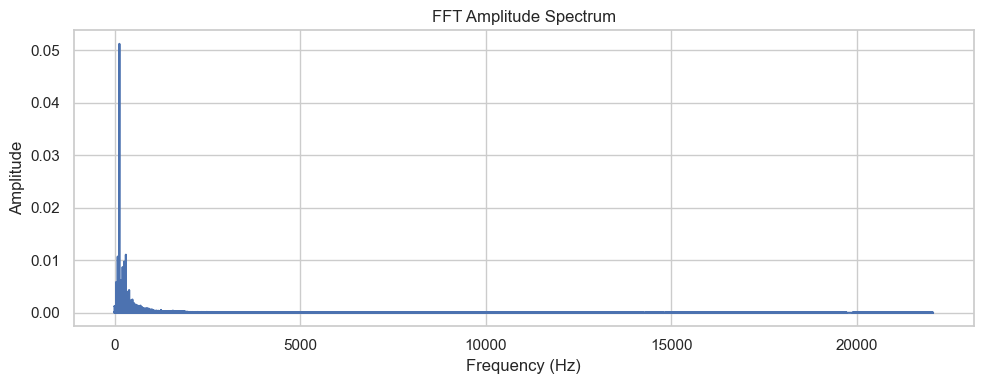

In [7]:
# FFT Analysis
print("FFT Analysis for Complete Recording:")
xf_complete, amplitudes_complete = compute_fft(audio_complete, sr_complete)
print("FFT Analysis for Anomalous Recording:")
xf_anomaly, amplitudes_anomaly = compute_fft(audio_anomaly, sr_anomaly)
print("FFT Analysis for Normal Recording:")
xf_normal, amplitudes_normal = compute_fft(audio_normal, sr_normal)


In [ ]:
# STFT Analysis
print("STFT for Complete Recording:")
stft_complete = compute_stft(audio_complete, sr_complete)
print("STFT for Anomalous Recording:")
stft_anomaly = compute_stft(audio_anomaly, sr_anomaly)
print("STFT for Normal Recording:")
stft_normal = compute_stft(audio_normal, sr_normal)


Wavelet Transform for Complete Recording:


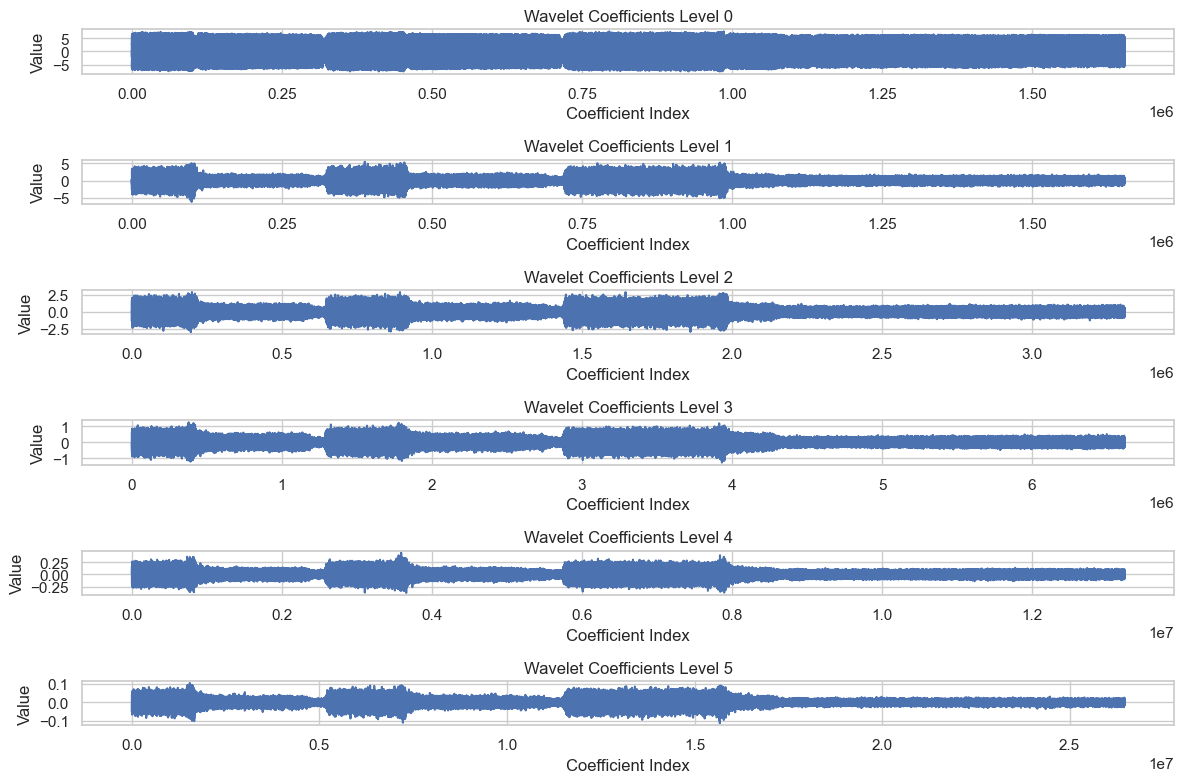

Wavelet Transform for Anomalous Recording:


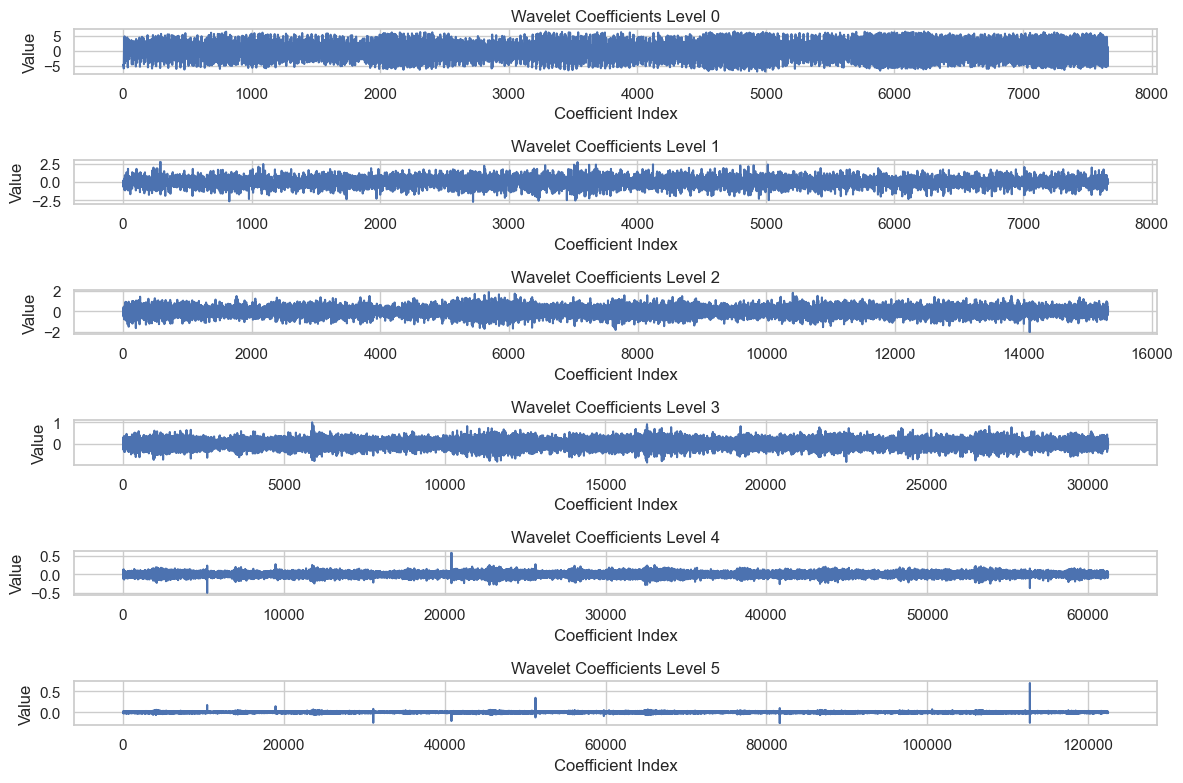

Wavelet Transform for Normal Recording:


In [ ]:
# Wavelet Transform Analysis
print("Wavelet Transform for Complete Recording:")
coeffs_complete = compute_wavelet(audio_complete, wavelet='db4', level=5)
print("Wavelet Transform for Anomalous Recording:")
coeffs_anomaly = compute_wavelet(audio_anomaly, wavelet='db4', level=5)
print("Wavelet Transform for Normal Recording:")
coeffs_normal = compute_wavelet(audio_normal, wavelet='db4', level=5)


## 7. Observations and Conclusions
#
- The raw waveforms and Mel-spectrograms reveal distinct patterns between the complete, anomalous, and normal recordings.
- High-level features such as MFCCs, spectral metrics, and zero-crossing rate provide a compact summary of each recording.
- FFT, STFT, and wavelet transform analyses offer complementary insights:
  - **FFT** exposes dominant frequency content.
  - **STFT** reveals time-varying spectral patterns.
  - **Wavelet Transform** captures multi-resolution, transient events.
#
These analyses collectively lay the groundwork for further modeling and anomaly detection.